In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from math import radians, sin, cos, asin, sqrt
import re
import requests
from datetime import time, timedelta, datetime
from statistics import median, quantiles


import geohash2
import pyproj
from pyproj import Proj, transform, CRS
from functools import partial
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from scipy.stats import poisson

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.linear_solver import pywraplp

import random
from tqdm import tqdm
from time import sleep

# Data Loading

## Loading functions

In [15]:
def calculate_demand(row):
    probabilities = {
        '0-10': 0,
        '10-20': 0.003458068783068975,
        '20-30': 0.013896825396825975,
        '30-40': 0.02136825396825512,
        '40-50': 0.02338333333333506,
        '50-60': 0.026277248677250214,
        '60-70': 0.03332089947090043,
        '70-80': 0.046515343915346036,
        '80+': 0.046515343915346036,
    }

    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand * 365


def setup_customer_data():
    customers_gdf = gpd.read_file('./Wuerzburg_Data/cluster_wuerzburg.gpkg')
    customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

    customers_gdf['nachfrage'] = customers_gdf.apply(calculate_demand, axis=1)

    bevoelkerung_sum = customers_gdf[customers_gdf['cluster'] != -1].groupby('cluster')['sum_INSGESAMT_0'].sum()
    noise_demand = customers_gdf[customers_gdf['cluster'] == -1]['nachfrage'].iloc[0]

    # Verteilung des Noise-Bedarfs auf die anderen Cluster anteilig zur Anzahl der Polygone
    for cluster in bevoelkerung_sum.index:
        cluster_demand = noise_demand * (bevoelkerung_sum[cluster] / bevoelkerung_sum.sum())
        customers_gdf.loc[customers_gdf['cluster'] == cluster, 'nachfrage'] += np.round(cluster_demand)

    customers_gdf = customers_gdf[customers_gdf['cluster'] != -1].reset_index(drop=True)
    # Set Index to cluster id
    customers_gdf.set_index(['cluster'], inplace=True)

    return customers_gdf


def load_energy_costs():
    # Calculate timestamps (current time minus 48 hours and current time)
    current_time = datetime.now()
    past_timestamp = (current_time - timedelta(days=365)).timestamp() * 1000
    current_timestamp = current_time.timestamp() * 1000

    # Construct the API URL with updated timestamps
    api_url = f"https://api.awattar.de/v1/marketdata?start={past_timestamp}&end={current_timestamp}"

    # Send GET request using the requests library
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an exception for non-2xx status codes
    except requests.exceptions.RequestException as error:
        print(f"Error: {error}")

    # Load data in json format
    data_energy = json.loads(response.content)
    # Extract market prices
    market_prices = [item["marketprice"] for item in data_energy["data"]]

    # Calculate quantiles
    q1, q2, q3 = quantiles(market_prices)  # Use quartiles function
    # Transform to Eur/kWh
    q1_kwh_eur = q1 / 1000
    q2_kwh_eur = q2 / 1000
    q3_kwh_eur = q3 / 1000

    print(f"Median market price (kWh): {q2_kwh_eur:.5f} Eur/kWh")
    print(f"25th percentile (Q1, kWh): {q1_kwh_eur:.2f} Eur/kWh")
    print(f"75th percentile (Q3, kWh): {q3_kwh_eur:.2f} Eur/kWh")

    return data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur


def calculate_travel_distance(warehouses_gdf, customers_gdf):
    # Create an empty list to store the results
    data = []
    # Iterate through each warehouse in the warehouse DataFrame
    for warehouse_index, warehouse in warehouses_gdf.iterrows():
        for customer_index, customer in customers_gdf.iterrows():
            # Calculate the distance between the centroid of the region and the warehouse
            travel_distance = warehouse.geometry.distance(customer.geometry.centroid)/1000
            # Append the calculated values to the list
            data.append({'warehouse_id': warehouse_index, 'region_id': customer_index, 'travel_distance': travel_distance})
    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    return df


def load_data(customers_gdf):
    
    # Grenzen des Simulationsrahmens laden
    geo_würzburg = gpd.read_file('./Wuerzburg_Data/geo_wuerzburg.gpkg')

    # Detaillierte Gebäude/Personen Daten laden
    bevölkerungs_gdf = gpd.read_file('./Wuerzburg_Data/pharmacy_assigned_complete.gpkg')
    bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
    bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)

    # Apotheken Daten laden
    pharmacy_df = pd.read_csv('./Wuerzburg_Data/Würzburg-Apotheken.csv')
    pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
    pharmacy_gdf = pharmacy_gdf.to_crs(bevölkerungs_gdf.crs)

    # Warehouse Daten laden
    warehouses_gdf = gpd.read_file('./Wuerzburg_Data/warehouses_wuerzburg.gpkg')

    # Distanzmatrix der Cluster und Warehouses erstellen
    shifts_df = calculate_travel_distance(warehouses_gdf, customers_gdf)
    shifts_df.set_index(['warehouse_id', 'region_id'], inplace=True)

    #Loading the energy_data
    data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur = load_energy_costs()

    return geo_würzburg, bevölkerungs_gdf, pharmacy_gdf, warehouses_gdf, shifts_df, data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur


## Load the data

In [16]:
customers_gdf = setup_customer_data()
geo_würzburg, bevölkerungs_gdf, pharmacy_gdf, warehouses_gdf, shifts_df, data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur = load_data(customers_gdf)

Median market price (kWh): 0.08210 Eur/kWh
25th percentile (Q1, kWh): 0.06 Eur/kWh
75th percentile (Q3, kWh): 0.10 Eur/kWh


# Plotting the Data

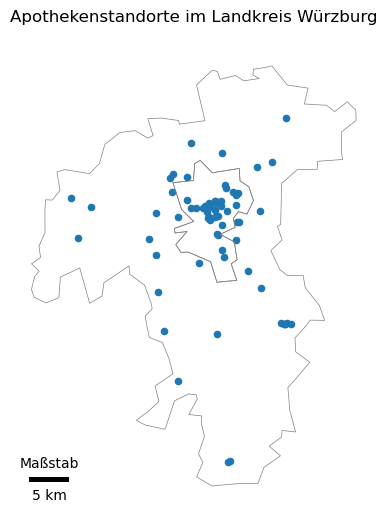

In [17]:
# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
pharmacy_gdf.plot(ax=ax, markersize=20)

# Titel hinzufügen
plt.title('Apothekenstandorte im Landkreis Würzburg')
plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

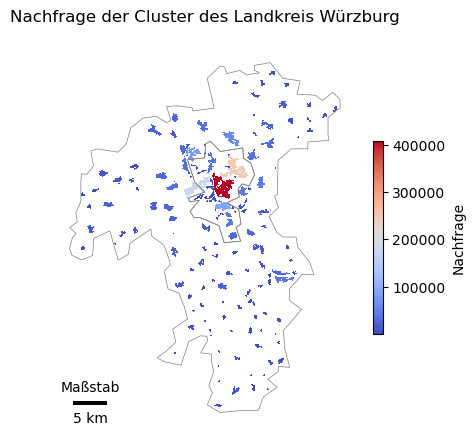

In [18]:
# Create a colormap based on the "nachfrage" column
vmin = customers_gdf['nachfrage'].min()
vmax = customers_gdf['nachfrage'].max()
cmap = 'coolwarm'  

# Plot the raster with boundary
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (5,5))

# Plot the customers with custom colormap
customers_gdf.plot(ax=ax, column='nachfrage', cmap=cmap, vmin=vmin, vmax=vmax)

# Add title and labels
plt.axis('off')
plt.title('Nachfrage der Cluster des Landkreis Würzburg')
#plt.xlabel('Breitengradkoordinate im CSR3035 Format')
#plt.ylabel('Längengradkoordinate im CSR3035 Format')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Nachfrage')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

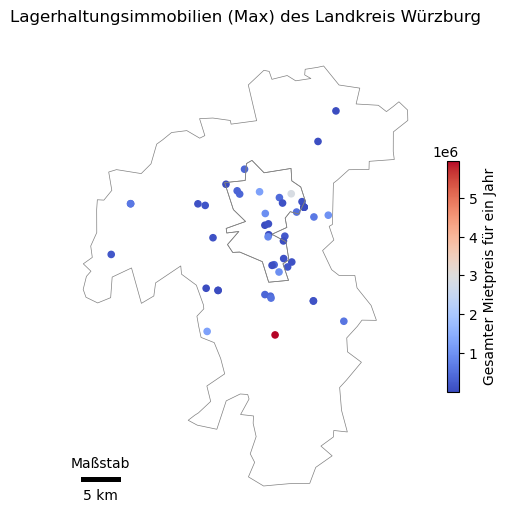

In [19]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_big'].min()
vmax = warehouses_gdf['total_price_big'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_big', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Max) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

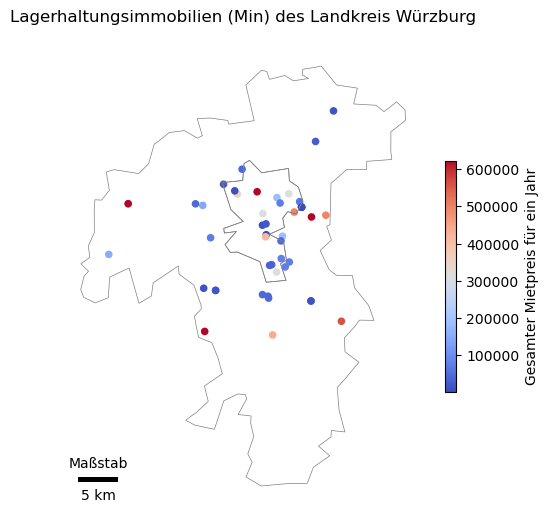

In [20]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_small'].min()
vmax = warehouses_gdf['total_price_small'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_small', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Min) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

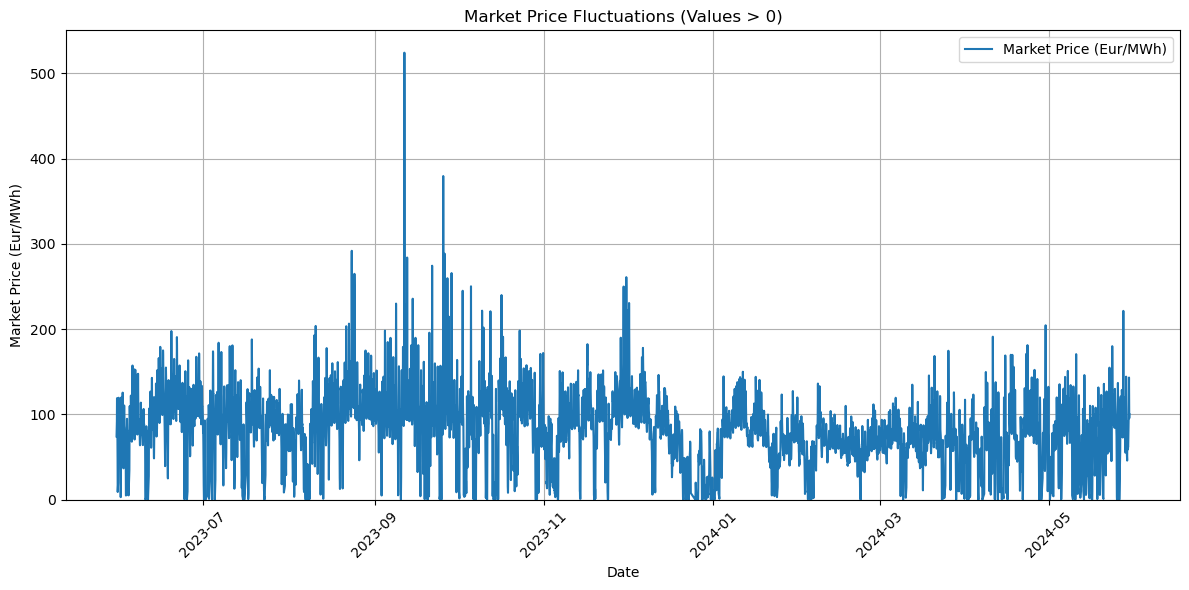

In [21]:
# Convert JSON data to pandas DataFrame
df_energy = pd.DataFrame(data_energy["data"])

# Convert timestamps to datetime format
df_energy["start_timestamp"] = pd.to_datetime(df_energy["start_timestamp"], unit="ms")
df_energy["end_timestamp"] = pd.to_datetime(df_energy["end_timestamp"], unit="ms")

# Filter data for values greater than 0
df_filtered = df_energy[df_energy["marketprice"] > 0]

# Plot market price vs timestamps (using filtered data)
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(df_filtered["start_timestamp"], df_filtered["marketprice"], label="Market Price (Eur/MWh)")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Market Price (Eur/MWh)")
plt.title("Market Price Fluctuations (Values > 0)")  # Update title

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y-axis limits to start from 0 (optional)
plt.ylim(bottom=0)  # This ensures the y-axis starts at 0

# Add gridlines
plt.grid(True)

# Show legend
plt.legend()

plt.tight_layout()
plt.show()

# Optimierungsmodel

## Optimierung

In [ ]:
#Time Window in the simulation -> daily simulation and given a certain time window which needs to be fullfilled


# Eine Apotheke im städtischen München hat 14 Mal Notdienst pro Jahr, im ländlicheren Rothenburg dagegen über 70 Mal.
# 20.000 Patienten versogt, 1.407.000 Packungen abgegeben von 1.405 Mio. Packungen = 100 % = 0.00100142348% in den Nachtdiensten abgegeben

In [ ]:
factory_setup_costs = 100000 #Eur     
qm_per_customer = 0.05 #Quadratmeter
minimum_square_requirement = 50 #Quadratmeter
rent_factor = 1 #Prozent

max_flight_distance = 20 #km
drone_initial_costs = 4000 #Eur
drone_speed = 80/60 #km/h/60 = km/min

time_window = 630 #Min
start_time = time(8, 0) #Time
end_time = time(18, 30) #Time
drone_prep_time = 10 #Min
night_shift_dist = 0.00100142348 #Prozent
demand_factor = 1 #Prozent
drone_puffer = 2

battery_capacity_mAh = 4000
battery_voltage = 11.1
kwh_eur = q2_kwh_eur

# Car/Truck Parameters:
cost_per_km_car = 0.38

In [ ]:
def optimize(W,
             R,
             S,
             cost_per_km_drone,
             factory_setup_costs, 
             qm_per_customer, 
             minimum_square_requirement, 
             rent_factor, 
             max_flight_distance, 
             drone_initial_costs, 
             drone_speed, 
             time_window, 
             drone_prep_time,
             night_shift_dist, 
             demand_factor, 
             drone_puffer):
    
    M = 1000000000
    
    # Create a solver
    solver = pywraplp.Solver('FacilityLocation', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Define decision variables
    # Which warehouse serves which region
    x = {}
    for w, r in S:
        x[w,r] = solver.BoolVar(name=f'x_{w}_{r}')

    # Which warehouses are opened
    y = {}
    # How many drones are needed in each warehouse
    z = {}
    # How much space is rented in each warehouse
    d = {}
    for w in W:
        y[w] = solver.BoolVar(name=f'y_{w}')
        z[w] = solver.IntVar(0, solver.infinity(), name=f'z_{w}')
        d[w] = solver.IntVar(0, solver.infinity(), name=f'd_{w}')
        
    # Objective Function
    objective = solver.Objective()
    
    
    # Fixed costs for opening warehouses
    for w in W:
        objective.SetCoefficient(y[w], factory_setup_costs)  # Add fixed factory setup costs
        objective.SetCoefficient(d[w], warehouses_gdf.loc[w, 'pricePerSquareMetre'] * rent_factor)  # Cost per square meter

        
    # Costs for acquiring drones
    for w in W:
        objective.SetCoefficient(z[w], drone_initial_costs)
    
    # Variable costs for transportation
    for w, r in S:
        objective.SetCoefficient(x[w,r], cost_per_km_drone * shifts_df.loc[w,r].travel_distance * 2 * customers_gdf.loc[r, 'nachfrage'] * demand_factor)

    objective.SetMinimization()
    
    # Constraints
    # Regions can only be served by open warehouses
    for w in W:
        for r in R:
            solver.Add(x[w,r] <= y[w])

    # Each region has to be served by exactly one warehouse
    for r in R:
        solver.Add(solver.Sum(x[w,r] for w in W) == 1)

    # Each warehouse needs to be assigned with a certain amount of drones
    for w in W:
        total_travel_time = solver.Sum(x[w, r] * shifts_df.loc[w, r].travel_distance * 2 * drone_puffer * (((customers_gdf.loc[r, 'nachfrage'] * (1 - night_shift_dist)) / 365) / drone_speed) for r in R) / time_window
        solver.Add(total_travel_time <= z[w])

    # Each warehouse is assigned a certain amound of space that is between the boundries of the offering
    for w in W:
        solver.Add(y[w] * warehouses_gdf.loc[w, 'floorSpace_small'] <= d[w])
        solver.Add(y[w] * warehouses_gdf.loc[w, 'floorSpace_big'] >= d[w])
        
    # The distance from warehouse to customer can't be taller than the maximum flight range of each drone
    for w in W:
        for r in R:
            solver.Add(x[w,r] * shifts_df.loc[w,r].travel_distance <= max_flight_distance)

    # Each warehouse has to fulfill a certain minimum space requirement
    for w in W:
        solver.Add(y[w] * minimum_square_requirement <= warehouses_gdf.loc[w, 'floorSpace_small'])

    # Each warehouse needs a certain amount of space for each customer served
    for w in W:
        customer_demand_sum = solver.Sum(x[w, r] * customers_gdf.loc[r, 'sum_INSGESAMT_0'] for r in R)
        solver.Add((customer_demand_sum / 12 * qm_per_customer) <= y[w] * warehouses_gdf.loc[w, 'floorSpace_small'])

    return solver, x, y, z, d


## Lösungsausgabe

In [ ]:
def solve(W, R, solver, x, y, z, d, customers_gdf_run, warehouses_gdf_run):
  opened_warehouses = []
  customers_gdf_run['assigned_warehouse'] = 0
  warehouses_gdf_run['number_of_drones'] = 0
  warehouses_gdf_run['floor_space_assigned'] = 0

  #Solving the problem
  status = solver.Solve()

  def print_solution(status, solver, x, y, z, d, W, R):

    if status == pywraplp.Solver.OPTIMAL:
      print("Objective value:", solver.Objective().Value())
      print("Opened warehouses:")
      opened_warehouses.clear()  # Clear the list before appending
      for w in W:
        if y[w].solution_value() > 0.5:
          opened_warehouses.append(w)
          warehouses_gdf_run.loc[w, 'number_of_drones'] = z[w].solution_value()
          warehouses_gdf_run.loc[w, 'floor_space_assigned'] = d[w].solution_value()
          print(f"- Warehouse {w}")
          print(f"Floor-Space: {d[w].solution_value()}")
          print(f"Drones needed: {z[w].solution_value()}")
      print("Warehouse assignments:")
      for r in R:
        assigned_warehouse = None
        for w in W:
          if x[w, r].solution_value() > 0.5:
            assigned_warehouse = w
            break
        if assigned_warehouse:
          customers_gdf_run.loc[r, 'assigned_warehouse'] = assigned_warehouse
          print(f"- Region {r} served by warehouse {assigned_warehouse}")
          distance = shifts_df.loc[assigned_warehouse, r].travel_distance
          print(f"- Distance: {distance}")
        else:
          print(f"- Region {r} has no assigned warehouse (might be infeasible)")
    else:
      print("Solver failed to find an optimal solution. Status:", status)


  print_solution(status, solver, x, y, z, d, W, R)
  
  return opened_warehouses, customers_gdf_run, warehouses_gdf_run

## Solution Graphics

In [ ]:
#Rahmen der Grafik definieren
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (7,7))

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].plot(ax=ax, color='red', marker='o', markersize=25)
warehouses_gdf.loc[opened_warehouses].plot(ax=ax, color='blue', marker='^', markersize=35)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Add legend
custom_legend = [Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Geöffnet'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Nicht geöffnet')]
plt.legend(handles=custom_legend, title='Warenhäuser', bbox_to_anchor=(1,0.95), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
plt.tight_layout()

# # Index jedes Warehouses anzeigen
# for idx, row in warehouses_gdf.loc[opened_warehouses].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# for idx, row in warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap with a color for each opened warehouse
colors = plt.cm.tab20(np.linspace(0, 1, len(opened_warehouses)))
warehouse_colors = dict(zip(opened_warehouses, colors))

# Create a dictionary to map each warehouse to a color
warehouse_colors = {
    warehouse: color
    for warehouse, color in zip(opened_warehouses, warehouse_colors.values())
}

# Plot the boundaries of the region
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize=(8, 8))


# Plot the customers with the color of their assigned warehouse
for index, row in customers_gdf.iterrows():
    warehouse = row['assigned_warehouse']
    color = warehouse_colors.get(warehouse, 'gray')  # Use gray color if warehouse is not in the dictionary
    customers_gdf.iloc[[index]].plot(ax=ax, color=color, markersize=20)


# Plot the warehouses with their assigned colors
for warehouse, color in warehouse_colors.items():
    warehouses_gdf[warehouses_gdf.index == warehouse].plot(ax=ax, color=color, marker='^', markersize=50, edgecolor='black')


# Turn off axis
plt.axis('off')

# Add title
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

# Add legend
legend_handles = [Line2D([0], [0], marker='^', color='w', markerfacecolor=color, markersize=10, label=warehouse) for warehouse, color in warehouse_colors.items()]
ax.legend(handles=legend_handles, title='Warenhäuser', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=2)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Show the plot
plt.show()

## Assigning a warehouse to each building based on the optimal value

In [ ]:
# Funktion, um das zugewiesene Lager für einen Punkt zu finden
def find_assigned_warehouse(point, customers_gdf_run, cluster_sindex):
    
    # Räumlichen Index für das Cluster-GDF erstellen
    

    possible_matches_index = list(cluster_sindex.intersection(point.bounds))
    possible_matches = customers_gdf_run.iloc[possible_matches_index]
    output = possible_matches[possible_matches.geometry.contains(point)]
    if not output.empty:
        return [output.assigned_warehouse.iloc[0]]
    else:
        nearest_polygon_index = cluster_sindex.nearest(point)[0]
        nearest_polygon = customers_gdf_run.iloc[nearest_polygon_index]
        return [nearest_polygon.assigned_warehouse.iloc[0]]

In [ ]:
def assign_warehouses(bevölkerungs_gdf_run, customers_gdf_run):
    # Verfolgen Sie den Fortschritt der apply-Methode
    tqdm.pandas()
    
    cluster_sindex = customers_gdf_run.sindex

    # Die apply-Methode auf die GeoDataFrame anwenden, um das zugewiesene Lager für jeden Punkt zu finden
    warehouses = bevölkerungs_gdf_run['geometry'].progress_apply(find_assigned_warehouse, customers_gdf_run = customers_gdf_run, cluster_sindex = cluster_sindex)

    bevölkerungs_gdf_run['assigned_warehouse'] = 0
    bevölkerungs_gdf_run['distance_warehouse'] = 0

    for index, row in tqdm(bevölkerungs_gdf_run.iterrows(), total=len(bevölkerungs_gdf_run)):
        bevölkerungs_gdf_run.loc[index, 'assigned_warehouse'] = warehouses[index][0]
        warehouse_geometry = warehouses_gdf.loc[row['assigned_warehouse'], 'geometry']
        population_geometry = row['geometry']
        bevölkerungs_gdf_run.loc[index, 'distance_warehouse'] = warehouse_geometry.distance(population_geometry) / 1000

    return bevölkerungs_gdf_run

## Simulations Loop

In [ ]:
def calculate_demand(row, probabilities):
    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand

In [ ]:
def assign_random_timestamp(row, night_shift_dist, start_time, end_time):
    timestamp_list = []
    for i in range(row['nachfrage']): 
        probabilities_timestamp = [1 - night_shift_dist, night_shift_dist]  # Wahrscheinlichkeit für innerhalb und außerhalb der Öffnungszeiten

        start_hour = start_time.hour
        start_minute = start_time.minute
        end_hour = end_time.hour
        end_minute = end_time.minute

        if np.random.choice([False, True], p=probabilities_timestamp):
            # Außerhalb der Öffnungszeiten
            if random.choice([True, False]):
                # Vor den Öffnungszeiten
                hour = random.randint(0, start_hour - 1)
                minute = random.randint(0, 59)
                second = random.randint(0, 59)
            else:
                # Nach den Öffnungszeiten
                hour = random.randint(end_hour + 1, 23)
                minute = random.randint(0, 59)
                second = random.randint(0, 59)
        else:
            # Innerhalb der Öffnungszeiten
            if start_hour == end_hour:
                hour = start_hour
                minute = random.randint(start_minute, end_minute)
            else:
                hour = random.randint(start_hour, end_hour)
                if hour == start_hour:
                    minute = random.randint(start_minute, 59)
                elif hour == end_hour:
                    minute = random.randint(0, end_minute)
                else:
                    minute = random.randint(0, 59)
            second = random.randint(0, 59)
        
        timestamp = datetime.combine(datetime.today(), datetime.min.time()) + timedelta(hours=hour, minutes=minute, seconds=second)
        timestamp_list.append(timestamp)
    return timestamp_list

In [ ]:
def calculate_penalty_costs(bevoelkerungs_gdf_sim, warehouses_gdf_sim, drone_speed, time_window, drone_prep_time):
    # Convert time_window to a timedelta object
    time_window = timedelta(minutes=time_window)

    # Initialize a dictionary to keep track of next available times for drones in each warehouse
    warehouse_drones = {warehouse: [datetime.min] * warehouses_gdf_sim.loc[warehouse, 'number_of_drones'] for warehouse in warehouses_gdf_sim.index}

    total_exceeded_minutes = 0

    # Flatten the demand timestamps and associate them with their warehouses and distances
    all_demands = []
    for index, row in bevoelkerungs_gdf_sim.iterrows():
        assigned_warehouse = row['assigned_warehouse']
        distance_warehouse = row['distance_warehouse']
        for timestamp in row['demand_timestamp']:
            all_demands.append((assigned_warehouse, distance_warehouse, timestamp))

    # Sort all demands by timestamp
    all_demands.sort(key=lambda x: x[2])

    # Process each demand
    for assigned_warehouse, distance_warehouse, timestamp in all_demands:

        # Find the first available drone
        available_drones = warehouse_drones[assigned_warehouse]
        next_available_time = min(available_drones)
        start_time = max(timestamp, next_available_time) + timedelta(minutes=drone_prep_time)  # Use start_time to calculate when the drone can actually start

        # Calculate the delivery time
        delivery_time = start_time + timedelta(minutes=distance_warehouse / drone_speed) 

        # Check if the delivery time exceeds the time window
        if (delivery_time - timestamp) > time_window:
            exceeded_minutes = ((delivery_time - timestamp) - time_window).total_seconds() / 60
            total_exceeded_minutes += exceeded_minutes

        # Update the next available time for the drone
        return_trip_end_time = delivery_time + timedelta(minutes=distance_warehouse / drone_speed)
        available_drones[available_drones.index(next_available_time)] = return_trip_end_time

    return total_exceeded_minutes

In [ ]:
def simulate(opened_warehouses_run, bevölkerungs_gdf_run, warehouses_gdf_run, cost_per_km_drone, drone_speed, time_window, start_time, end_time, drone_prep_time, night_shift_dist, cost_per_km_car):

    # Wahrscheinlichkeitsverteilung
    probabilities_demand = {
        '0-10': 0,
        '10-20': 0.003458068783068975,
        '20-30': 0.013896825396825975,
        '30-40': 0.02136825396825512,
        '40-50': 0.02338333333333506,
        '50-60': 0.026277248677250214,
        '60-70': 0.03332089947090043,
        '70-80': 0.046515343915346036,
        '80+': 0.046515343915346036,
    }

    #Calculate the monthly fix costs due to drone and factory setup
    factory_setup_cost = 0
    drone_setup_cost = 0

    drone_transportation_cost = 0
    drone_transportation_time = 0
    time_penalty_costs = 0

    car_transportation_cost = 0
    car_transportation_time = 0
    tqdm.pandas()

    #Loop der Simulation über ein gesamtes Jahr
    for i in range(2):

        print(f'Simulation - Tag: {i + 1}')
        
        
        bevölkerungs_gdf_run['nachfrage'] = 0
        bevölkerungs_gdf_run['nachfrage'] = bevölkerungs_gdf_run.progress_apply(calculate_demand, axis=1, probabilities = probabilities_demand)
        bevölkerungs_gdf_run['demand_timestamp'] = bevölkerungs_gdf_run.progress_apply(lambda row: assign_random_timestamp(row, night_shift_dist, start_time, end_time), axis=1)

        # Calculate transportation costs and time using vectorized operations
        drone_transportation_cost += np.sum(bevölkerungs_gdf_run['nachfrage'] * bevölkerungs_gdf_run['distance_warehouse'] * cost_per_km_drone * 2)
        time_penalty_costs += calculate_penalty_costs(bevölkerungs_gdf_run, warehouses_gdf_run, drone_speed, time_window, drone_prep_time)

        car_transportation_cost += np.sum(bevölkerungs_gdf_run['nachfrage'] * bevölkerungs_gdf_run['distance_pharmacy'] * cost_per_km_car * 2)
        car_transportation_time += np.sum(bevölkerungs_gdf_run['nachfrage'] * bevölkerungs_gdf_run['time_pharmacy'])
        

    return [factory_setup_cost, drone_setup_cost, drone_transportation_cost, drone_transportation_time, time_penalty_costs, car_transportation_cost, car_transportation_time]

In [ ]:
def print_cost_summary(costs):

  print("-" * 50)
  print("Logistical Cost Summary (per year):")
  print("-" * 50)
  print(f"Factory Setup Cost: \t€{costs[0]:.2f}")
  print(f"Drone Setup Cost: \t\t\t€{costs[1]:.2f}")
  print("-" * 50)
  print(f"Drone Transportation Cost: \t€{costs[2]:.2f}")
  print(f"Drone Transportation Time: \t\t\t€{costs[3]:.2f}")
  print(f"Transportation Penalty Cost: \t\t\t€{costs[4]:.2f}")
  print("-" * 50)
  print(f"Car/Truck Transportation Cost: \t€{costs[5]:.2f}")
  print(f"Car/Truck Transportation Time: \t{costs[6]/ 60:.2f} hours")
  print("-" * 50)

# Robustheit / Parameter Changes

## First optimal run

In [ ]:
def run(parameter_values, bevölkerungs_gdf_run, warehouses_gdf_run, customers_gdf_run, shifts_df_run):

    battery_capacity_wh = parameter_values[14] * parameter_values[15]
    battery_capacity_j = battery_capacity_wh * 3600  # J # Convert battery capacity from Wh to J
    Epm = battery_capacity_j / (parameter_values[4] * 1000)  # J/m # Energy per meter in Joules
    kWh_km = Epm * 1000 / 3600000  # kWh/km # Convert energy per meter to kWh per kilometer
    cost_per_km_drone = parameter_values[16] * kWh_km  # EUR/km # Calculate cost per kilometer for the drone
    
    W = warehouses_gdf_run.index.values
    R = customers_gdf_run.index.values
    S = shifts_df_run.index.values

    result = []
    
    # Set the optimization problem
    solver, x, y, z, d = optimize(W,
                                R,
                                S, 
                                cost_per_km_drone, 
                                parameter_values[0], 
                                parameter_values[1], 
                                parameter_values[2], 
                                parameter_values[3], 
                                parameter_values[4], 
                                parameter_values[5], 
                                parameter_values[6], 
                                parameter_values[7], 
                                parameter_values[10],
                                parameter_values[11],
                                parameter_values[12],
                                parameter_values[13])

    print('Solver set up!')

    # Solve the problem and get the solution
    opened_warehouses, customers_gdf_run, warehouses_gdf_run = solve(W, R, solver, x, y, z, d)

    # Assign the in the solution chosen warehouses in the dataset
    bevölkerungs_gdf_run = assign_warehouses(bevölkerungs_gdf_run)
    print('Dataset set up!')

    # Simulate with optimal values
    costs = simulate(opened_warehouses, 
                     bevölkerungs_gdf_run, 
                     warehouses_gdf_run, 
                     cost_per_km_drone, 
                     parameter_values[6],
                     parameter_values[7],
                     parameter_values[8],
                     parameter_values[9],
                     parameter_values[10],
                     parameter_values[11],
                     parameter_values[17])
    print('Simulation done!')
    print_cost_summary()

    result.append({
    'opened_warehouses': opened_warehouses,
    'objective_value': solver.Objective().Value(),
    })

    return result        

## Sensitivity Analysis

In [ ]:
def sensitivity_analysis(parameter_values, number_of_runs, sensitivity_index, parameter_names):

    triangular_values = np.random.triangular(parameter_values[sensitivity_index][0], parameter_values[sensitivity_index][1], parameter_values[sensitivity_index][2], number_of_runs)
    bevölkerungs_gdf_run = bevölkerungs_gdf
    warehouses_gdf_run = warehouses_gdf
    customers_gdf_run = customers_gdf
    shifts_df_run = shifts_df

    result_list = []

    for i in range(number_of_runs):
    
        if sensitivity_index != 'None':
            parameter_values[sensitivity_analysis][1] = triangular_values[i]

        results = run(parameter_values, bevölkerungs_gdf_run, warehouses_gdf_run, customers_gdf_run, shifts_df_run)

        result_list.append({
            'parameter': parameter_names[sensitivity_index],
            'parameter_value': triangular_values[i],
            'results': results
        })
    
    return result_list

# Complete Loop

In [ ]:
def find_min_travel_distance(shifts_df):
    # Initialize variables
    min_distance = 0
    max_distance = shifts_df['travel_distance'].max()
    shifts_df.reset_index(inplace=True)

    while min_distance <= max_distance:

        current_distance = min_distance + 0.1

        # Assuming 'node_a' and 'node_b' are columns containing node IDs, and 'distance' is the distance column
        filtered_data = shifts_df[shifts_df['travel_distance'] < current_distance]

        all_regions = shifts_df.region_id.unique()
        filtered_regions = filtered_data.region_id.unique()  
        region_present = set(all_regions).issubset(set(filtered_regions))

        if region_present:
            break
        else:
            min_distance = current_distance  # Update min distance if condition not met

    shifts_df.set_index(['warehouse_id', 'region_id'], inplace=True)
    return min_distance  # Minimum distance found

In [ ]:
factory_setup_costs = 100000 #Eur     
qm_per_customer = 0.05 #Quadratmeter
minimum_square_requirement = 50 #Quadratmeter
rent_factor = 1 #Prozent

max_flight_distance = 20 #km
drone_initial_costs = 4000 #Eur
drone_speed = 80/60 #km/h/60 = km/min

time_window = 630 #Min
start_time = time(8, 0) #Time
end_time = time(18, 30) #Time
drone_prep_time = 10 #Min
night_shift_dist = 0.00100142348 #Prozent
demand_factor = 1 #Prozent
drone_puffer = 2

battery_capacity_mAh = 4000
battery_voltage = 11.1
kwh_eur = q2_kwh_eur

# Car/Truck Parameters:
cost_per_km_car = 0.38

parameter_values = []
parameter_names = []

complete_analysis = []

for i in range(len(parameter_values)):
    complete_analysis.append(sensitivity_analysis(parameter_values, 1, 'None', parameter_names))
    complete_analysis.append(sensitivity_analysis(parameter_values, 1, i, parameter_names))


# Tests

In [ ]:
# max_flight_distance: km - Maximale Flugreichweite eines Drohnenfluges. Diese Variable definiert die maximale Distanz, die eine Drohne zurücklegen kann, bevor der Akku leer ist.

# qm_per_customer: Quadratmeter - Benötigte Lagerfläche pro Kunde. Diese Variable gibt an, wie viel Quadratmeter Lagerfläche pro Kunde benötigt werden.

# minimum_square_requirement: Quadratmeter - Mindestanforderung an Lagerfläche für ein Lagerhaus. Diese Variable definiert die minimale Lagerfläche, die ein Lagerhaus haben muss, um in Betrieb genommen zu werden.

# factory_setup_costs: EUR - Einrichtungs- und Installationskosten für ein neues Lagerhaus. Diese Variable gibt die festen Kosten an, die anfallen, wenn ein neues Lagerhaus eröffnet wird.

# drone_initial_costs: EUR - Anschaffungskosten pro Drohne. Diese Variable definiert die Kosten, die für den Kauf jeder einzelnen Drohne anfallen.

# drone_speed: km/h/60 = km/min - Geschwindigkeit der Drohne in Kilometern pro Minute. Diese Variable gibt die Geschwindigkeit der Drohne an und wird verwendet, um die Reisedauer zu berechnen.

# service_time: Minuten - Servicezeit pro Drohne pro Tag. Diese Variable definiert die maximale Betriebszeit einer Drohne pro Tag, um die Anzahl der benötigten Drohnen zu berechnen.

# night_shift_dist: Prozent - Anpassungsfaktor für die Nachtschicht. Diese Variable wird verwendet, um den Einfluss der Nachtschicht auf die Distanzberechnungen oder den Betrieb zu berücksichtigen.

# demand_factor: Prozent - Anpassungsfaktor für die Nachfrage. Diese Variable ermöglicht die Anpassung der Gesamtnachfrage nach Dienstleistungen oder Produkten, um Simulationen oder verschiedene Szenarien zu berücksichtigen.

# rent_factor: Prozent - Anpassungsfaktor für die Mietkosten. Diese Variable erlaubt es, die Mietkosten für Lagerhäuser zu modifizieren, um unterschiedliche Szenarien oder Preisänderungen zu simulieren.

In [ ]:
max_flight_distance = 20 #km
qm_per_customer = 0.05 #Quadratmeter
minimum_square_requirement = 50 #Quadratmeter
factory_setup_costs = 100000 #Eur
drone_initial_costs = 4000 #Eur
drone_speed = 80/60 #km/h/60 = km/min
service_time = 630 #Min
night_shift_dist = 0.00100142348 #Prozent
demand_factor = 1 #Prozent
rent_factor = 1 #Prozent
drone_puffer = 2

battery_capacity_mAh = 4000
voltage = 11.1
battery_capacity_wh = battery_capacity_mAh * voltage
battery_capacity_j = battery_capacity_wh * 3600  # J # Convert battery capacity from Wh to J
Epm = battery_capacity_j / (max_flight_distance * 1000)  # J/m # Energy per meter in Joules
kWh_km = Epm * 1000 / 3600000  # kWh/km # Convert energy per meter to kWh per kilometer
cost_per_km_drone = q2_kwh_eur * kWh_km  # EUR/km # Calculate cost per kilometer for the drone


# Car/Truck Parameters:
cost_per_km_car = 0.38



W = warehouses_gdf.index.values
R = customers_gdf.index.values
S = shifts_df.index.values

# Set the optimization problem
solver, x, y, z, d = optimize(W,
                              R,
                              S, 
                              cost_per_km_drone, 
                              max_flight_distance, 
                              qm_per_customer, 
                              factory_setup_costs, 
                              minimum_square_requirement, 
                              drone_initial_costs, 
                              drone_speed, 
                              service_time, 
                              night_shift_dist, 
                              rent_factor,
                              demand_factor,
                              drone_puffer)
print('Solver set up!')

# Solve the problem and get the solution
opened_warehouses, customers_gdf, warehouses_gdf  = solve(W, R, solver, x, y, z, d, customers_gdf, warehouses_gdf)


In [ ]:
bevölkerungs_gdf = assign_warehouses(bevölkerungs_gdf, customers_gdf)

In [ ]:
time_window = 630
start_time = time(8, 0)
end_time = time(18, 30)
drone_prep_time = 5


In [ ]:
costs = simulate(opened_warehouses, bevölkerungs_gdf, warehouses_gdf, cost_per_km_drone, cost_per_km_car, night_shift_dist, time_window, start_time, end_time, drone_speed, drone_prep_time)